In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap
import logging 


logger = logging.getLogger(__name__)

# Example FIPS dictionary
fips_dict = {
    'state': 'Massachusetts',
    'state_fips': '25',
    'county': 'Suffolk',
    'county_fips': '025'
}
# Folder:
state = fips_dict.get('state')
county = fips_dict.get('county')
state_fips = fips_dict.get('state_fips')
county_fips = fips_dict.get('county_fips')

if not all([state, county, state_fips, county_fips]):
    logger.error("Missing required keys in fips_dict: state, county, state_fips, county_fips")

output_dir = Path("gridtracer/data_processor/output")
state_dir = state.replace(' ', '_')
county_dir = county.replace(' ', '_')
nlcd_dir = output_dir / "NLCD" / state_dir / county_dir
nlcd_dir.mkdir(parents=True, exist_ok=True)

output_file = nlcd_dir / f"nlcd_2023_{state_fips}_{county_fips}.tif"

# Extract region of interest: 
region_boundary = gpd.read_file("/Users/magic-rabbit/Documents/00_Tech-Repositories/05_MASTER_THESIS/gridtracer/gridtracer/data_processor/output/MA/Middlesex_County/Cambridge_city/Census/25_017_11000_blocks_boundary.geojson")



In [16]:
def nlcd_landuse_data_preprocessing(region_boundary, input_file_path=None, output_dir=None):
    """
    Extract data for a specific region from NLCD landuse dataset and save as GeoTIFF.
    
    Parameters:
    -----------
    region_boundary : GeoDataFrame
        GeoDataFrame outlining the region of interest (e.g., county or subdivision).
    fips_dict : dict
        Dictionary containing region metadata.
    input_file_path : str or Path
        Path to the NLCD landuse GeoTIFF file.
    output_dir : str or Path
        Output directory path.
    
    Returns:
    --------
    str : Path to the extracted GeoTIFF file if successful, None otherwise
    """
    input_file = Path(input_file_path)
    if not input_file.exists():
        logger.error(f"Input file not found: {input_file}")
        return None


    try:
        with rasterio.open(input_file) as src:
            nlcd_crs = src.crs
            logger.info(f"NLCD dataset CRS: {nlcd_crs}")

            if region_boundary.crs != nlcd_crs:
                logger.info(f"Reprojecting region to match NLCD CRS: {nlcd_crs}")
                region_boundary = region_boundary.to_crs(nlcd_crs)

            geoms = [mapping(geom) for geom in region_boundary.geometry.values]
            out_meta = src.meta.copy()

            try:
                out_image, out_transform = mask(src, geoms, crop=True, all_touched=True)
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "compress": "DEFLATE"
                })

                with rasterio.open(output_file, "w", **out_meta) as dest:
                    dest.write(out_image)

                logger.info(f"Saved clipped NLCD raster to: {output_file}")
                return str(output_file)

            except Exception as clip_err:
                logger.error(f"Rasterio clipping failed: {clip_err}")
                logger.info("Falling back to GDAL translate")

                try:
                    minx, miny, maxx, maxy = region_boundary.total_bounds
                    gdal_cmd = [
                        "gdal_translate", "-projwin", str(minx), str(maxy), str(maxx), str(miny),
                        "-of", "GTiff", "-co", "COMPRESS=DEFLATE", "-co", "PREDICTOR=2",
                        str(input_file), str(output_file)
                    ]
                    subprocess.run(gdal_cmd, check=True)

                    subprocess.run(["gdaladdo", "-r", "nearest", str(output_file), "2", "4", "8", "16"], check=True)

                    logger.info(f"GDAL extraction succeeded: {output_file}")
                    return str(output_file)

                except subprocess.CalledProcessError as gdal_err:
                    logger.error(f"GDAL extraction failed: {gdal_err}")
                    return None

    except Exception as e:
        logger.error(f"Unexpected error: {e}")
        return None


In [17]:
extracted_file = nlcd_landuse_data_preprocessing(region_boundary, input_file_path="/Users/magic-rabbit/Documents/MA-data/nlcd_2023.tif")

print(extracted_file)

gridtracer/data_processor/output/NLCD/Massachusetts/Suffolk/nlcd_2023_25_025.tif


In [18]:
def interpret_nlcd_class(value):
    """
    Interpret NLCD land use/land cover class values.
    
    Parameters:
    -----------
    value : int
        NLCD class value (11-95)
    
    Returns:
    --------
    tuple : (class_name, class_description, category) if known, ("Unknown", None, None) otherwise
    """
    # NLCD 2023 classification scheme
    nlcd_classes = {
        # Water
        11: ("Open Water", "All areas of open water with less than 25% vegetation/land cover", "Water"),
        12: ("Perennial Ice/Snow", "Areas characterized by year-round ice/snow cover", "Water"),
        
        # Developed
        21: ("Developed, Open Space", "Mostly vegetation (lawns) with some constructed materials; impervious surfaces <20%", "Developed"),
        22: ("Developed, Low Intensity", "Mix of vegetation and constructed materials; impervious surfaces 20-49%", "Developed"),
        23: ("Developed, Medium Intensity", "Mix of vegetation and constructed materials; impervious surfaces 50-79%", "Developed"),
        24: ("Developed, High Intensity", "Highly developed areas; impervious surfaces 80-100%", "Developed"),
        
        # Barren
        31: ("Barren Land", "Bedrock, desert pavement, scarps, talus, slides, sand dunes, gravel pits", "Barren"),
        
        # Forest
        41: ("Deciduous Forest", "Trees >5m tall are >20% vegetation, >75% of trees shed foliage", "Forest"),
        42: ("Evergreen Forest", "Trees >5m tall are >20% vegetation, >75% of trees maintain leaves", "Forest"),
        43: ("Mixed Forest", "Trees >5m tall are >20% vegetation, neither deciduous nor evergreen >75%", "Forest"),
        
        # Shrubland
        52: ("Shrub/Scrub", "Shrubs <5m tall are >20% vegetation", "Shrubland"),
        
        # Herbaceous
        71: ("Grassland/Herbaceous", "Graminoid or herbaceous vegetation >80%", "Herbaceous"),
        72: ("Sedge/Herbaceous", "Sedges and forbs >80% vegetation", "Herbaceous"),
        73: ("Lichens", "Lichens >80% vegetation", "Herbaceous"),
        74: ("Moss", "Moss >80% vegetation", "Herbaceous"),
        
        # Planted/Cultivated
        81: ("Pasture/Hay", "Grasses/legumes for livestock grazing or hay production", "Agriculture"),
        82: ("Cultivated Crops", "Annual crops, vineyards, orchards", "Agriculture"),
        
        # Wetlands
        90: ("Woody Wetlands", "Forest/shrubland vegetation >20%, soil periodically saturated", "Wetlands"),
        95: ("Emergent Herbaceous Wetlands", "Perennial herbaceous vegetation >80%, soil periodically saturated", "Wetlands"),
    }
    
    if value in nlcd_classes:
        return nlcd_classes[value]
    else:
        return ("Unknown", None, None)
    
    
    

Land use classes in Suffolk County:
Class 11: Open Water - Water
Class 21: Developed, Open Space - Developed
Class 22: Developed, Low Intensity - Developed
Class 23: Developed, Medium Intensity - Developed
Class 24: Developed, High Intensity - Developed
Class 41: Deciduous Forest - Forest
Class 42: Evergreen Forest - Forest
Class 71: Grassland/Herbaceous - Herbaceous
Class 90: Woody Wetlands - Wetlands
Class 95: Emergent Herbaceous Wetlands - Wetlands


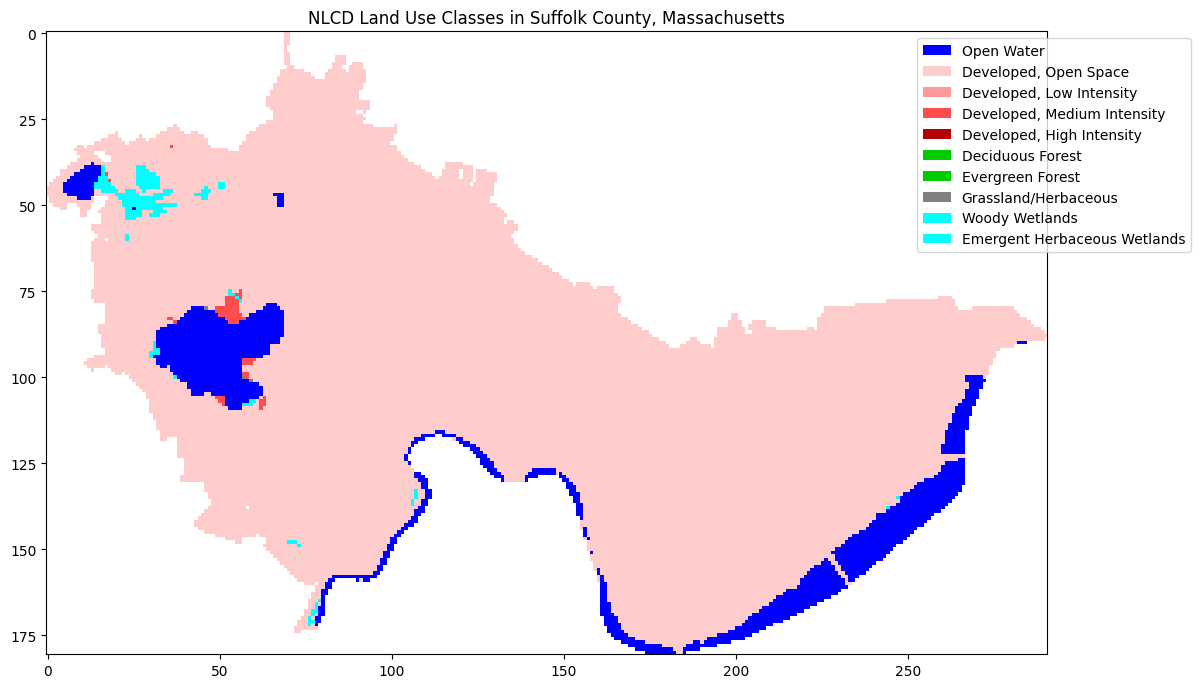

In [19]:
if extracted_file:
    # Read the data
    with rasterio.open(extracted_file) as src:
        nlcd_data = src.read(1)
        
        # Create a mask for valid data (not NoData)
        valid_mask = nlcd_data != src.nodata
        
        # Get unique classes present in this county
        unique_classes = np.unique(nlcd_data[valid_mask])
        
        print(f"Land use classes in {fips_dict['county']} County:")
        for cls in unique_classes:
            name, desc, category = interpret_nlcd_class(cls)
            print(f"Class {cls}: {name} - {category}")
            
        # Create a custom colormap for visualization
        colors = []
        labels = []
        
        for i in range(100):
            if i in unique_classes:
                name, _, category = interpret_nlcd_class(i)
                labels.append(name)
                
                # Assign colors based on category
                if category == "Water":
                    colors.append([0, 0, 1, 1])  # Blue
                elif category == "Developed":
                    if i == 21:  # Developed, Open Space
                        colors.append([1, 0.8, 0.8, 1])  # Light pink
                    elif i == 22:  # Developed, Low Intensity
                        colors.append([1, 0.6, 0.6, 1])  # Light red
                    elif i == 23:  # Developed, Medium Intensity
                        colors.append([1, 0.3, 0.3, 1])  # Medium red
                    elif i == 24:  # Developed, High Intensity
                        colors.append([0.7, 0, 0, 1])  # Dark red
                elif category == "Forest":
                    colors.append([0, 0.8, 0, 1])  # Green
                elif category == "Agriculture":
                    colors.append([1, 1, 0, 1])  # Yellow
                elif category == "Wetlands":
                    colors.append([0, 1, 1, 1])  # Cyan
                else:
                    colors.append([0.5, 0.5, 0.5, 1])  # Gray
                    
        # Plot the data
        plt.figure(figsize=(12, 10))
        masked_data = np.ma.masked_where(~valid_mask, nlcd_data)
        plt.imshow(masked_data, cmap=ListedColormap(colors), interpolation='none')
        plt.title(f"NLCD Land Use Classes in {fips_dict['county']} County, {fips_dict['state']}")
        
        # Add a legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=colors[unique_classes.tolist().index(cls)], 
                                 label=interpret_nlcd_class(cls)[0])
                           for cls in unique_classes]
        plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
        
        plt.tight_layout()
        plt.savefig(f"nlcd_{fips_dict['state']}_{fips_dict['county']}.png", dpi=300)
        plt.show()

In [20]:
if extracted_file:
    # Read the data
    with rasterio.open(extracted_file) as src:
        nlcd_data = src.read(1)
        transform = src.transform
        crs = src.crs
        
        # Create a mask for valid data (not NoData)
        valid_mask = nlcd_data != src.nodata
        
        # Get unique classes present in this county
        unique_classes = np.unique(nlcd_data[valid_mask])
        
        # Visualization code (unchanged)
        # ...
        
        # Export to shapefile with class attributes
        import rasterio.features
        import geopandas as gpd
        from shapely.geometry import shape
        
        # Create a dictionary to store class metadata
        class_info = {}
        for cls in unique_classes:
            name, desc, category = interpret_nlcd_class(cls)
            class_info[cls] = {
                'name': name,
                'description': desc,
                'category': category
            }
        
        # Vectorize the raster data
        shapes = []
        for cls in unique_classes:
            class_mask = nlcd_data == cls
            if np.any(class_mask):
                for geom, val in rasterio.features.shapes(
                    nlcd_data.astype('uint8'),
                    mask=class_mask,
                    transform=transform
                ):
                    shapes.append({
                        'geometry': shape(geom),
                        'class_id': int(val),
                        'class_name': class_info[int(val)]['name'],
                        'description': class_info[int(val)]['description'],
                        'category': class_info[int(val)]['category']
                    })
        
        # Create a GeoDataFrame and export to shapefile
        gdf = gpd.GeoDataFrame(shapes)
        gdf.crs = crs
        output_shapefile = nlcd_dir / f"nlcd_{fips_dict['state']}_{fips_dict['county']}.shp"
        gdf.to_file(output_shapefile)
        print(f"Exported NLCD data to shapefile: {output_shapefile}")

Exported NLCD data to shapefile: gridtracer/data_processor/output/NLCD/Massachusetts/Suffolk/nlcd_Massachusetts_Suffolk.shp


/var/folders/65/9j_wpsj10wdgptqdmzhrcwqm0000gn/T/ipykernel_78682/3746501932.py:54: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile)
/Users/magic-rabbit/Documents/00_Tech-Repositories/05_MASTER_THESIS/gridtracer/.venv/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'description' to 'descriptio'
  ogr_write(
